In [1]:
from pathlib import Path
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

from chorus.model import load_model
from chorus.train import get_model_data

In [2]:
model = load_model(Path('../models/e/0131.pth'), device='cuda')

In [3]:
# Model was trained on just the top five most common species.
# We'll also load the next five most common species to see
# how well the model can "extrapolate".
additional_targets = [
    "Song Sparrow",
    "Carolina Wren",
    "Northern Cardinal",
    "American Robin",
    "Red Crossbill",
    "Red-winged Blackbird",
    "House Wren",
    "Bewick's Wren",
    "Dark-eyed Junco",
    "Blue Jay",
]

In [4]:
train, test = get_model_data(additional_targets)

In [5]:
def get_features_and_labels(song_data):
    feats_list = []
    labels_list = []
    for x, label in song_data:
        feats_list.append(
            model.forward(x.cuda()[None, :], include_top=False)
            .detach().cpu().numpy()[0]
        )
        labels_list.append(label.numpy())

    return np.stack(feats_list), np.stack(labels_list)

In [6]:
feats_train, labels_train = get_features_and_labels(train)
feats_train.shape

(2878, 32)

In [7]:
lr = OneVsRestClassifier(LogisticRegression(max_iter=1_000, random_state=9651))
lr.fit(feats_train, labels_train);

In [8]:
feats_test, labels_test = get_features_and_labels(test)
feats_test.shape

(720, 32)

The left column shows species that were explicitly trained on.
The right column shows species that were not trained on.


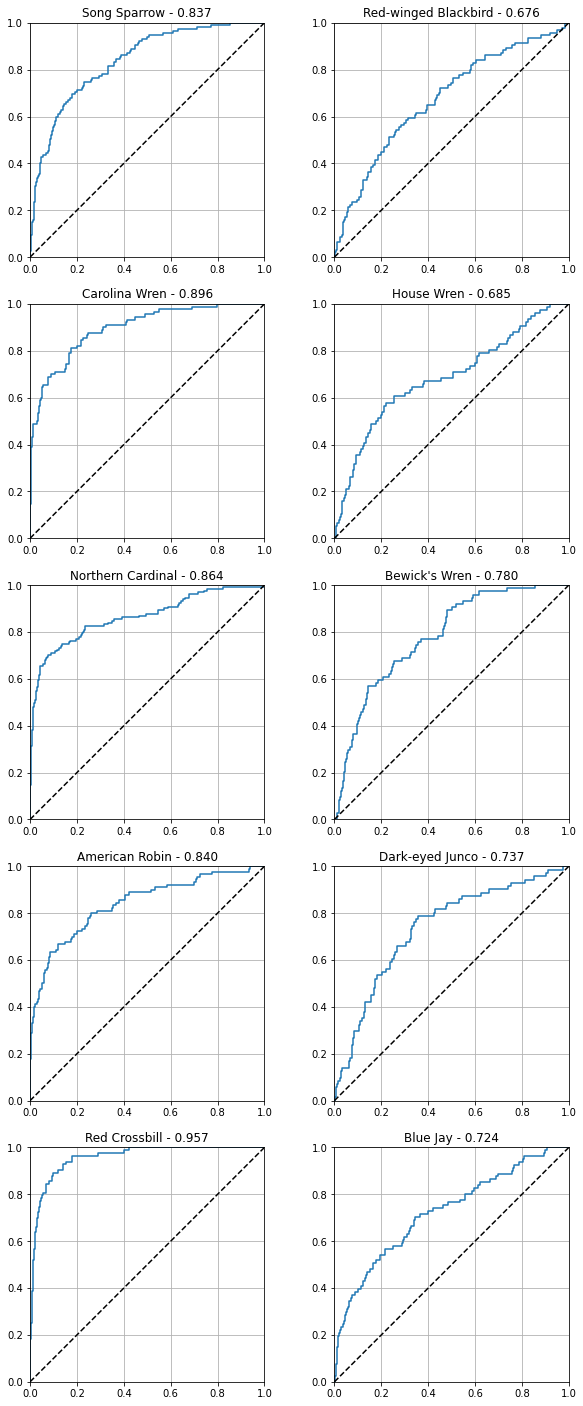

In [9]:
preds = lr.predict_proba(feats_test)

f, axs = plt.subplots(len(additional_targets) // 2, 2, figsize=(10, 25))
axs = axs.T.flatten()
for i, target in enumerate(additional_targets):
    fprs, tprs, _ = roc_curve(labels_test[:, i], preds[:, i])
    axs[i].plot(fprs, tprs)
    axs[i].plot([0, 1], [0, 1], 'k--')
    axs[i].set_aspect('equal')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].grid()
    auc = roc_auc_score(labels_test[:, i], preds[:, i])
    axs[i].set_title(f'{target} - {auc:.3f}')

print('The left column shows species that were explicitly trained on.')
print('The right column shows species that were not trained on.')

plt.show()